In [43]:
from utils import read_gt, HOG_descriptor
from utils import one_hot_encoder, read_gt
from skimage.transform import resize
from skimage.color import rgb2luv, rgb2gray
from skimage.feature import local_binary_pattern

import cv2 as cv
import numpy as np
import tqdm
import time
import pickle
import os
import math
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

kmeans_hog = pickle.load(open('./Models/kmeans_hog.sav', 'rb'))
rf = pickle.load(open('./Models/rf.sav', 'rb'))
svm = pickle.load(open('./Models/svm.sav', 'rb'))
xgb = pickle.load(open('./Models/xgb.sav', 'rb'))

img_path = ['./img1/'+img_name for img_name in os.listdir('./img1/')]
img = cv.imread(img_path[0])
img = resize(img, output_shape=(430, 640), 
                 anti_aliasing=True, mode='reflect')

kmeans_hog = pickle.load(open('./Models/kmeans_hog.sav', 'rb'))
kmeans_lbp = pickle.load(open('./Models/kmeans_lbp.sav', 'rb'))
kmeans_luv = pickle.load(open('./Models/kmeans_luv.sav', 'rb'))

gt = read_gt('./gt/gt.txt')
for bb in gt:
    bb[2] = math.floor(bb[2]/2)
    bb[3] = math.floor(bb[3]/2)
    bb[4] = math.ceil(bb[4]/2)
    bb[5] = math.ceil(bb[5]/2)

/home/kai/.local/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


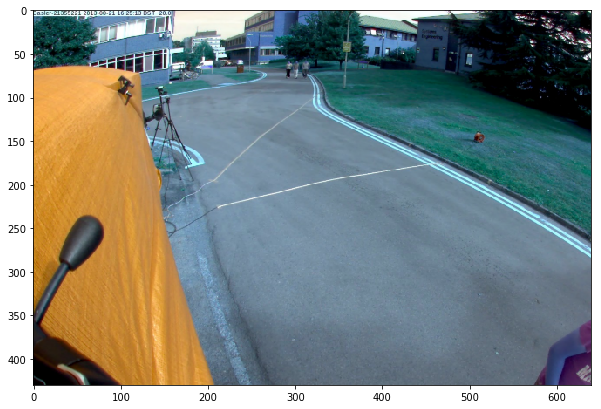

In [2]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [60]:
def sliding_window(img_shape, stepSizes, windowSizes):
    # slide a window across the image
    windows = []
    if not isinstance(stepSizes, list):
        stepSizes = [stepSizes]
    if len(windowSizes)==2 and not isinstance(windowSizes[0], list):
        windowSizes = [windowSizes]
    if (not len(stepSizes)==len(windowSizes)) and (not len(stepSizes)==1):
        raise Exception('Lenght of step size and window size should be the same')
    elif (not len(stepSizes)==len(windowSizes)):
        stepSizes = [stepSizes[0] for i in windowSizes]
    
    for stepSize, windowSize in zip(stepSizes, windowSizes):
        for y in range(0, img_shape[0]-windowSize[0], stepSize):
            for x in range(0, img_shape[1]-windowSize[1], stepSize):
                # yield the current window
                windows += [(-1, -1, x, y, windowSize[1], windowSize[0])]
    return windows
            
def bag_of_features(img_kmeans, bb_list, mode='normal'):
    
    if not isinstance(bb_list[0], list) and not isinstance(bb_list[0], tuple):
        bb_list = [bb_list]
    
    features = []
    
    for bb in bb_list:
        x, y, dx, dy = bb[2:]
        
        if mode=='normal':
            pos = img_kmeans[y:y+dy, x:x+dx, :]
            pos = np.reshape(pos, (pos.shape[0]*pos.shape[1], -1))
        elif mode=='hog':
            y1 = math.floor((y-8)/8)
            if y1<0:
                y1 = 0
            y2 = math.ceil((y+dy-8)/8)
            x1 = math.floor((x-8)/8)
            if x1<0:
                x1 = 0
            x2 = math.ceil((x+dx-8)/8)

            if y1==y2:
                y2 += 1
            if x1==x2:
                x2 += 1

            pos = img_kmeans[y1:y2, x1:x2, :]
            pos = np.reshape(pos, (pos.shape[0]*pos.shape[1], -1))
        
        feature = np.sum(pos, axis=0, keepdims=True)
        feature = feature/np.sum(feature)
        features += [feature]
    
    return np.concatenate(features, axis=0)

def unpackbits(x, num_bits):
    xshape = list(x.shape)
    x = x.reshape([-1,1])
    to_and = 2**np.arange(num_bits).reshape([1,num_bits])
    return (x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits])

def kmeans_for_img(kmeans, img):
    h, w, ch = img.shape
    img = np.reshape(img, (h*w, ch))
    img = kmeans.predict(img)
    img = one_hot_encoder(img, 64)
    img = np.reshape(img, (h, w, 64))
    return img

In [82]:
stepSizes = [4, 8, 10, 20, 30]
windowSizes = [[20, 50], [40, 110], [50, 150], [100, 300], [150, 300]]
windows = sliding_window(img.shape, stepSizes=stepSizes, windowSizes=windowSizes)

# hog features
print('hog feature being extracted...')
start = time.time()
img_fd, _ = HOG_descriptor(img)
img_fd = kmeans_for_img(kmeans_hog, img_fd)
features_hog = bag_of_features(img_fd, windows, mode='hog')
end = time.time()
print('Time:', end-start)

# lbp features
print('lbp feature being extracted...')
start = time.time()
img_gray = rgb2gray(img)
img_lbp = np.ndarray.astype(local_binary_pattern(img_gray, P=8*3, R=3), np.uint32)
lbp_feature = unpackbits(img_lbp, num_bits=24)
lbp_feature = kmeans_for_img(kmeans_lbp, lbp_feature)
features_lbp = bag_of_features(lbp_feature, windows)
end = time.time()
print('Time:', end-start)

# luv features
print('luv feature being extracted...')
start = time.time()
img_luv = rgb2luv(img)
img_luv = kmeans_for_img(kmeans_luv, img_luv)
features_luv = bag_of_features(img_luv, windows)
end = time.time()
print('Time:', end-start)

# features
features = np.concatenate([features_hog, features_lbp, features_luv], axis=1)

hog feature being extracted...
Time: 1.1461384296417236
lbp feature being extracted...
Time: 6.158472061157227
luv feature being extracted...
Time: 5.907591104507446


In [83]:
start = time.time()
y_train = svm.predict(features)
y_train_prob = svm.predict_proba(features)
end = time.time()
print('Time: ', end-start)
print(np.sum(y_train))
print(np.sum(y_train_prob[:, 1]>0.95))

ValueError: X.shape[1] = 192 should be equal to 450, the number of features at training time

In [21]:
start = time.time()
y_train = rf.predict(features)
y_train_prob = rf.predict_proba(features)
end = time.time()
print('Time: ', end-start)
print(np.sum(y_train))
print(np.sum(y_train_prob[:, 1]>0.70))

Time:  4.537837266921997
6712.0
220


In [22]:
start = time.time()
y_train = xgb.predict(features)
y_train_prob = xgb.predict_proba(features)
end = time.time()
print('Time: ', end-start)
print(np.sum(y_train))
print(np.sum(y_train_prob[:, 1]>0.95))

Time:  1.5893795490264893
480.0
236


In [23]:
ped_idx = np.where(y_train==1)
print(windows[ped_idx[0][-1]])

(-1, -1, 628, 364, 10, 20)


In [29]:
bb = [tmp for tmp in gt if tmp[0]==1]
features = bag_of_features(img_fd, kmeans_hog, bb)
start = time.time()
y_train = rf.predict(features)
y_train_prob = rf.predict_proba(features)
end = time.time()
print('Time: ', end-start)
print(np.sum(y_train))
print(y_train_prob[:, 1])


bb = [tmp for tmp in gt if tmp[0]==1]
features = bag_of_features(img_fd, kmeans_hog, bb)
start = time.time()
y_train = xgb.predict(features)
y_train_prob = xgb.predict_proba(features)
end = time.time()
print('Time: ', end-start)
print(np.sum(y_train))
print(y_train_prob[:, 1])


bb = [tmp for tmp in gt if tmp[0]==1]
features = bag_of_features(img_fd, kmeans_hog, bb)
start = time.time()
y_train = svm.predict(features)
y_train_prob = svm.predict_proba(features)
end = time.time()
print('Time: ', end-start)
print(np.sum(y_train))
print(y_train_prob[:, 1])


Time:  0.24434661865234375
4.0
[0.66818543 0.55658333 0.77901949 0.54382883]
Time:  0.519301176071167
4.0
[0.9996551  0.97041255 0.99893504 0.9955237 ]
Time:  0.01695418357849121
4.0
[0.93905669 0.77769407 0.96593024 0.660442  ]
